This notebook presents the Data Analysis for the dataset used

In [1]:
from src.recommender import parse_json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Reading the data from disk

In [2]:
reviews = parse_json("./data/australian_user_reviews.json")
user_items = parse_json("./data/australian_users_items.json")
steam_games = parse_json("./data/steam_games.json")

25799it [00:03, 7825.18it/s]


Reading 25799 rows.


88310it [02:19, 632.50it/s] 


Reading 88310 rows.


32135it [00:03, 9970.72it/s] 


Reading 32135 rows.


We start by taking a look at our users. 

We want to know how many items our users usually posses.

                 user_id  items_count
44154             dkimmm            0
50723  76561198042745849            0
50716  76561198042725721            0
50713  76561198042712452            0
50709  76561198042711240            0
...                  ...          ...
5995      mayshowganmore         5027
6022              piepai         6132
1104              chidvd         6410
19055       thugnificent         6700
3708             phrostb         7762

[88310 rows x 2 columns]
Average items in user inventory 72.06882132468114
 -> recall@k bounded by k/72.06882132468114


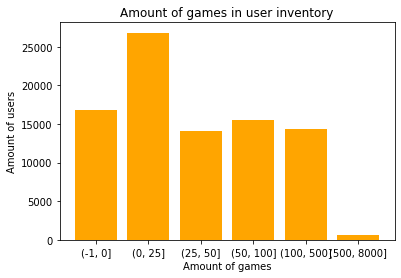

In [3]:
game_bin = [-1, 0, 25, 50, 100, 500, 8000]
user_item_count = user_items[["user_id", "items_count"]].copy()
user_item_count = user_item_count.sort_values("items_count")
print(user_item_count)
avg_usr_item_amount = user_item_count["items_count"].loc[(user_item_count["items_count"]!=0)].mean()
print("Average items in user inventory", avg_usr_item_amount)
print(f" -> recall@k bounded by k/{avg_usr_item_amount}")
user_item_count["items_count"] = pd.cut(user_item_count["items_count"], game_bin).apply(str)

user_item_count = user_item_count.groupby("items_count").count()

x = user_item_count["user_id"].index.to_numpy()
y = user_item_count["user_id"].to_numpy()   

plt.bar(x, y, color="orange")
plt.title("Amount of games in user inventory")
plt.xlabel("Amount of games")
plt.ylabel("Amount of users")
plt.show()

Now we check how many reviews our users usually have made.

                 user_id  reviews_count
25001  76561198102423654              0
24911  76561198100396147              0
7583   76561198079215291              0
9894   76561198061996985              0
21386  76561198063489150              0
...                  ...            ...
16268  76561198080345478             10
2848          TrackFight             10
19297         kiniston69             10
2911          Blackboy72             10
7071       SambaWarKiddo             10

[25799 rows x 2 columns]


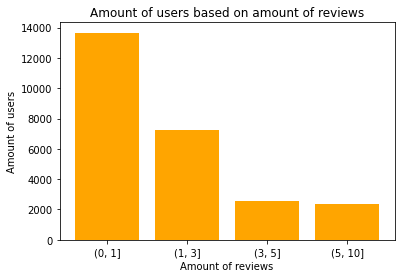

In [4]:
review_bins = [0, 1, 3, 5, 10]
user_review_count = reviews[["user_id", "reviews"]].copy()
user_review_count["reviews_count"] = user_review_count["reviews"].apply(len)
user_review_count = user_review_count.sort_values("reviews_count")
print(user_review_count[["user_id", "reviews_count"]])
user_review_count["reviews_count"] = pd.cut(user_review_count["reviews_count"], review_bins).apply(str)

user_review_count = user_review_count.groupby("reviews_count").count()

x = user_review_count["user_id"].index.to_numpy()
y = user_review_count["user_id"].to_numpy()   

plt.bar(x, y, color="orange")
plt.title("Amount of users based on amount of reviews")
plt.xlabel("Amount of reviews")
plt.ylabel("Amount of users")
plt.show()

Let's now look at the games, first we want to find out which are the most popular games.

items
Dota 2 Test                         49571
Counter-Strike: Global Offensive    43776
Garry's Mod                         43301
Unturned                            38682
Left 4 Dead 2                       37044
                                    ...  
Codex of Victory                        1
Shmups Skill Test                       1
Tradewinds Caravans                     1
Tradewinds Odyssey                      1
Rebel Wings                             1
Name: user_id, Length: 10947, dtype: int64


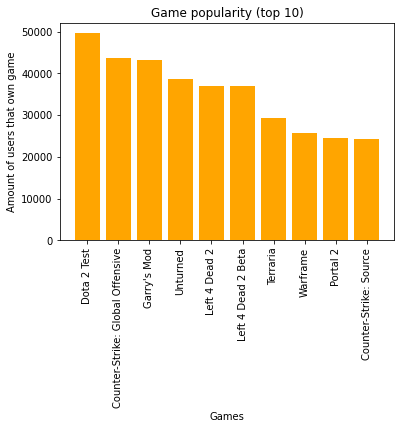

In [5]:
game_popularity = user_items[["user_id", "items"]].copy()
game_popularity = game_popularity.explode("items", ignore_index=True)
game_popularity.dropna(inplace=True)
game_popularity["items"] = game_popularity["items"].apply(lambda x: x["item_name"])
game_popularity = game_popularity.groupby("items").count()
game_popularity = game_popularity.sort_values("user_id", ascending=False)["user_id"]

print(game_popularity)

plt.bar(game_popularity[:10].index, game_popularity[:10].values, color="orange")
plt.tick_params(axis="x", rotation=90)
plt.title("Game popularity (top 10)")
plt.xlabel("Games")
plt.ylabel("Amount of users that own game")
plt.show()

Checking popularity based results

In [14]:
# compute top k popularity based recommender
k = 10

ground_truth = user_items[["user_id", "items"]].copy()
ground_truth["items"] = ground_truth["items"].apply(lambda x: [i["item_id"] for i in x])
ground_truth.dropna(inplace=True)

game_review_popularity = reviews[["user_id", "reviews"]].copy()
game_review_popularity["reviews"] = game_review_popularity["reviews"].apply(lambda x: [i["item_id"] for i in x])
game_review_popularity.dropna(inplace=True)

n_game_pop = game_review_popularity["reviews"].explode()
n_game_pop.dropna(inplace=True)
n_game_pop = n_game_pop.value_counts()

game_review_popularity["recommendations"] = game_review_popularity["reviews"].apply(lambda x: [rec for rec in n_game_pop.index if rec not in x][:10]) 
# print(recommendations)

# drop all rows with no items (nothing to compare against)
ground_truth = ground_truth.merge(game_review_popularity, on=['user_id'])
ground_truth['items'] = ground_truth.apply(lambda row: list(set(row['items']).difference(set(row['reviews']))), axis=1)
ground_truth.drop(ground_truth[~ground_truth['items'].astype(bool)].index, inplace=True)

# compute nDCG@k
ground_truth['nDCG@k'] = ground_truth.apply(lambda row: np.sum([int(rec in row['items'])/(np.log2(i+2)) for i, rec in enumerate(row["recommendations"])]), axis=1)
ground_truth['nDCG@k'] = ground_truth.apply(lambda row: row['nDCG@k']/np.sum([1/(np.log2(i+2)) for i in range(min(len(row["recommendations"]), len(row['items'])))]), axis=1)

# compute recall@k
ground_truth['items'] = ground_truth['items'].apply(set)
ground_truth["recommendations"] = ground_truth["recommendations"].apply(set)
ground_truth['recall@k'] = ground_truth.apply(lambda row: len(row["recommendations"].intersection(row['items']))/len(row['items']), axis=1)

ground_truth['ideal_recall@k'] = ground_truth.apply(lambda row: min(len(row['items']), len(row["recommendations"]))/len(row['items']), axis=1)

print(f"Popularity based top {k} recommender achieves: nDCG@{k}: {ground_truth['nDCG@k'].mean()}, recall@{k}: {ground_truth['recall@k'].mean()}")
print(f"The ideal recall@{k} = {ground_truth['ideal_recall@k'].mean()}, which makes nrecall@{k}: {ground_truth['recall@k'].mean()/ground_truth['ideal_recall@k'].mean()}")

Popularity based top 10 recommender achieves: nDCG@10: 0.46426623387011295, recall@10: 0.0722303553443824
The ideal recall@10 = 0.2167604954986081, which makes nrecall@10: 0.3332265650077655


In [7]:
print(f"Total amount of games on steam: {steam_games.shape[0]} with {game_popularity.shape[0]} that are actually owned in our dataset")

Total amount of games on steam: 32135 with 10947 that are actually owned in our dataset


Analysing the tags in our data

Let's first take a look at which tags are present.

In [8]:
game_tags = steam_games[["app_name", "genres", "tags", "specs"]].copy()

game_tags["genres"] = game_tags["genres"].fillna("").apply(set)
genre_set = set()
for s in game_tags.genres.values:
    genre_set.update(s)
game_tags["tags"] = game_tags["tags"].fillna("").apply(set)
tags_set = set()
for s in game_tags.tags.values:
    tags_set.update(s)
game_tags["specs"] = game_tags["specs"].fillna("").apply(set)
specs_set = set()
for s in game_tags.specs.values:
    specs_set.update(s)

all_tags = set.union(genre_set, tags_set, specs_set)
print(genre_set, "\n")
print(tags_set, "\n")
print(specs_set, "\n")
print(all_tags, "\n")

{'Animation &amp; Modeling', 'Racing', 'Indie', 'Strategy', 'Accounting', 'Web Publishing', 'Early Access', 'Software Training', 'Action', 'RPG', 'Free to Play', 'Education', 'Design &amp; Illustration', 'Adventure', 'Utilities', 'Audio Production', 'Casual', 'Massively Multiplayer', 'Simulation', 'Sports', 'Photo Editing', 'Video Production'} 

{"Beat 'em up", 'Text-Based', 'Local Multiplayer', 'Lemmings', 'Realistic', 'Walking Simulator', 'Robots', 'Cartoon', 'GameMaker', 'Crafting', 'Benchmark', 'Survival', 'Mining', 'Space', 'Economy', 'Twin Stick Shooter', 'Platformer', 'Match 3', 'Time Travel', 'TrackIR', 'Stylized', 'Soccer', 'Documentary', 'Visual Novel', 'Illuminati', 'Hardware', 'Clicker', 'Funny', 'Story Rich', 'Tanks', 'Level Editor', 'Photo Editing', 'Conversation', 'Difficult', 'Foreign', 'Mouse only', 'Cyberpunk', 'Strategy', 'Werewolves', 'Military', 'Quick-Time Events', 'Real-Time', 'Sci-fi', 'Wrestling', 'Programming', 'Diplomacy', 'Pool', 'Gore', 'Free to Play', 'Agr

Now let's see which are the most popular tags 

Average tag occurrence count 497.0964912280702
Indie                             17642
Action                            13018
Adventure                          9842
Casual                             9767
Simulation                         7749
                                  ...  
Intentionally Awkward Controls        6
Cycling                               5
Voice Control                         5
Faith                                 4
Bikes                                 2
Length: 342, dtype: int64


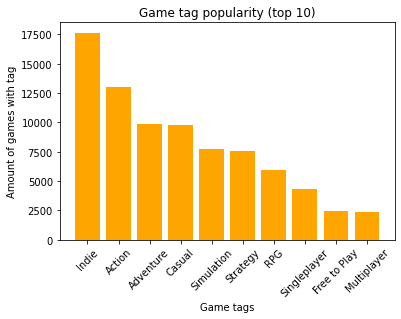

In [9]:
tag_amount = game_tags.apply(lambda x: set.union(x.genres, x.tags), axis=1).explode()
tag_popularity = tag_amount.value_counts()

tag_mean = tag_popularity.mean()

print("Average tag occurrence count", tag_mean)
print(tag_popularity)

plt.bar(tag_popularity[:10].index, tag_popularity[:10].values, color="orange")
plt.tick_params(axis="x", rotation=45)
plt.title("Game tag popularity (top 10)")
plt.xlabel("Game tags")
plt.ylabel("Amount of games with tag")
plt.show()

Checking tag frequency per game

Amount of tags: 342
                                            app_name  #tag
26972                                           Goro     0
7854            Football Manager 2017 In-Game Editor     0
30992                  Burn Zombie Burn!: Soundtrack     0
865                             Dustforce Soundtrack     0
31181  Total War: SHOGUN 2 - Sengoku Jidai Unit Pack     0
...                                              ...   ...
21131                               Wallpaper Engine    22
22238                     EF-12: Fighting Game Maker    22
26660                                       GameGuru    22
2800                                      Miscreated    23
14291                            - Occult preRaise -    24

[32135 rows x 2 columns]


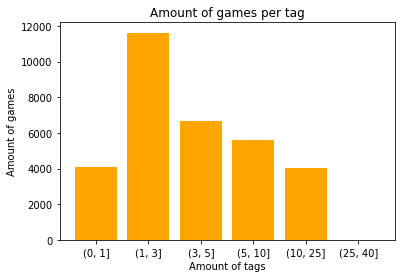

In [10]:
print("Amount of tags:", len(set.union(tags_set, genre_set)))

game_tags["#tag"] = game_tags.apply(lambda x: len(set.union(x.genres, x.tags)), axis=1)

print(game_tags[["app_name", "#tag"]].sort_values("#tag"))
tag_bin = [0, 1, 3, 5, 10, 25, 40]
game_tags["binned_tags"] = pd.cut(game_tags["#tag"], tag_bin).apply(str)

game_tags = game_tags.groupby("binned_tags").count()

x = game_tags["app_name"].index.to_numpy()
y = game_tags["app_name"].to_numpy()   

plt.bar(x, y, color="orange")
plt.title("Amount of games per tag")
plt.xlabel("Amount of tags")
plt.ylabel("Amount of games")
plt.show()
